# Joint modeling of neural and behavioural dynamics during dealyed reach task

In this example, we will show how to use the latentsde model to generate neural observations (spiking recordings of neurons in the dorsal premotor (PMd) and primary motor (M1) cortices) and behavioural observations (Hand velocity) of a monkey doing a dealyed reach task. 
The data is available for download [here](https://dandiarchive.org/#/dandiset/000128).


In [5]:
using Pkg, Revise, Lux, LuxCUDA, CUDA, Random, DifferentialEquations, SciMLSensitivity, ComponentArrays, Plots, MLUtils, OptimizationOptimisers, LinearAlgebra, Statistics, Printf, PyCall, Distributions
using IterTools: ncycle
using NeuroDynamics
np = pyimport("numpy")
device = "cpu"
const dev = device == "gpu" ? gpu_device() : cpu_device()


(::LuxCPUDevice) (generic function with 5 methods)

## 1. Loading the data and creating the dataloaders

You can prepare the data yourself or use our preprocessed data staright away which is available [here](https://drive.google.com/file/d/1J9)

In [23]:
file_path = "/Users/ahmed.elgazzar/Datasets/NLB/mc_maze.npy" # Replace with your path to the dataset
data = np.load(file_path, allow_pickle=true)
Y_neural = permutedims(get(data[1], "spikes") , [3, 2, 1])|> Array{Float32}
Y_behaviour = permutedims(get(data[1], "hand_vel") , [3, 2, 1])|> Array{Float32}
n_neurons = size(Y_neural)[1]
n_neurons , n_timepoints, n_trials = size(Y_neural);
n_behviour = size(Y_behaviour)[1]
ts = range(0, 4, length=n_timepoints);
ts_input = repeat(ts, 1, n_trials) 
U = reshape(ts_input, (1, size(ts_input)...))|> Array{Float32} 
n_ctrl = size(U)[1]
(U_train, Yn_train, Yb_train) , (U_test, Yn_test, Yb_test) = splitobs((U, Y_neural, Y_behaviour); at=0.7)
train_loader = DataLoader((U_train, Yn_train, Yb_train), batchsize=28, shuffle=true)
val_loader = DataLoader((U_test, Yn_test, Yb_test), batchsize=10, shuffle=true);

## 2. Defining the model 
- We will use a "Recurrent_Encoder" to infer the initial hidden state from a portion of the observations. 
- We will use a BlackBox (Neural) SDE with multiplicative noise to model the latent dynamics.
- We will use a multi-headed decoder, one for the neural observations and one for behaviour.

In [8]:
hp = Dict("n_states" => 16, "hidden_dim" => 64, "context_dim" => 32, "t_init" => Int(0.8 * n_timepoints))
rng = Random.MersenneTwister(1234)
obs_encoder = Recurrent_Encoder(n_neurons, hp["n_states"], hp["context_dim"], 32, hp["t_init"])
drift = Chain(Dense(hp["n_states"], hp["hidden_dim"], softplus), Dense(hp["hidden_dim"], hp["n_states"], tanh))
drift_aug = Chain(Dense(hp["n_states"] + hp["context_dim"] + n_ctrl, hp["hidden_dim"], softplus), Dense(hp["hidden_dim"], hp["n_states"],tanh))
diffusion = Scale(hp["n_states"], sigmoid, init_weight=identity_init(gain=0.1))
dynamics = SDE(drift, drift_aug, diffusion, EulerHeun(), saveat=ts, dt=ts[2]-ts[1])
obs_decoder = Chain(MLP_Decoder(hp["n_states"], n_neurons, 64, 1, "Poisson"), Lux.BranchLayer(NoOpLayer(), Linear_Decoder(n_neurons, n_behviour,"Gaussian")))

ctrl_encoder, ctrl_decoder = NoOpLayer(), NoOpLayer()
model = LatentUDE(obs_encoder, ctrl_encoder, dynamics, obs_decoder, ctrl_decoder, dev)
p, st = Lux.setup(rng, model)
p = p |> ComponentArray{Float32};


## 3. Training the model 

We will train the model using the AdamW optimizer with a learning rate of 1e-3 for 200 epochs. 


In [26]:
function train(model::LatentUDE, p, st, train_loader, val_loader, epochs, print_every)
    
    epoch = 0
    L = frange_cycle_linear(epochs+1, 0.5f0, 1.0f0, 1, 0.3)
    losses = []
    θ_best = nothing
    best_metric = -Inf
    println("Training ...")

    function loss(p, u, y_n, y_b)
        u, y_n, y_b  = u |> dev, y_n |> dev, y_b |> dev
        (ŷ_n, ŷ_b), _, x̂₀, kl_path = model(y_n, u, ts, p, st)
        batch_size = size(y_n)[end]
        neural_loss = - poisson_loglikelihood(ŷ_n, y_n)/batch_size
        behaviorual_loss = - normal_loglikelihood(ŷ_b..., y_b)
        obs_loss = neural_loss + behaviorual_loss
        kl_init = kl_normal(x̂₀[1], x̂₀[2])
        kl_path = mean(kl_path[end,:])
        kl_loss =  kl_path  +  kl_init
        l =  0.1*obs_loss + 10*L[epoch+1]*kl_loss
        return l, obs_loss, kl_loss
    end


    callback = function(opt_state, l, obs_loss , kl_loss)
        θ = opt_state.u
        push!(losses, l)
        if length(losses) % length(train_loader) == 0
            epoch += 1
        end

        if length(losses) % (length(train_loader)*print_every) == 0
            @printf("Current epoch: %d, Loss: %.2f, Observations_loss: %d, KL: %.2f\n", epoch, losses[end], obs_loss, kl_loss)
            u, y_n, y_b = first(train_loader) 
            (ŷ_n, ŷ_b), _, _ = predict(model, y_n, u, ts, θ, st, 20) 
            ŷ_n = dropdims(mean(ŷ_n, dims=4), dims=4)
            ŷ_b_m, ŷ_b_s = dropdims(mean(ŷ_b[1], dims=4), dims=4), dropdims(mean(ŷ_b[2], dims=4), dims=4)
            val_bps = bits_per_spike(ŷ_n, y_n)
            val_ll = normal_loglikelihood(ŷ_b_m, ŷ_b_s, y_b)
            @printf("Validation bits/spike: %.2f\n", val_bps)
            @printf("Validation behaviour log-likelihood: %.2f\n", val_ll)
            if val_ll > best_metric
                best_metric = val_ll
                 θ_best = copy(θ)
                 @printf("**** Saving best model ****\n")
                end   
            d = plot_preds(y_b,  ŷ_b[1])
            display(d)

        end
        return false
    end

    adtype = Optimization.AutoZygote()
    optf = OptimizationFunction((p, _ , u, y_n, y_b) -> loss(p, u, y_n, y_b), adtype)
    optproblem = OptimizationProblem(optf, p)
    result = Optimization.solve(optproblem, ADAMW(5e-4), ncycle(train_loader, epochs); callback)
    return model, θ_best
    
end


train (generic function with 1 method)

Training ...
Current epoch: 300, Loss: 13754.77, Observations_loss: 122863, KL: 220.47
Validation bits/spike: -163.88
Validation behaviour log-likelihood: -83500.04
**** Saving best model ****
Current epoch: 600, Loss: 13325.71, Observations_loss: 115519, KL: 213.03
Validation bits/spike: -163.49
Validation behaviour log-likelihood: -76605.81
**** Saving best model ****
Current epoch: 900, Loss: 12859.09, Observations_loss: 108960, KL: 196.44
Validation bits/spike: -157.98
Validation behaviour log-likelihood: -74892.60
**** Saving best model ****
Current epoch: 1200, Loss: 12679.57, Observations_loss: 107080, KL: 197.15
Validation bits/spike: -149.48
Validation behaviour log-likelihood: -72730.95
**** Saving best model ****
Current epoch: 1500, Loss: 12455.06, Observations_loss: 105150, KL: 194.01
Validation bits/spike: -137.28
Validation behaviour log-likelihood: -71983.67
**** Saving best model ****
Current epoch: 1800, Loss: 12004.27, Observations_loss: 100103, KL: 199.40
Validation

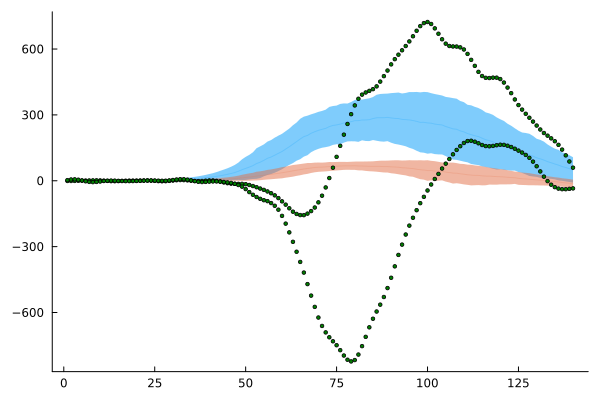

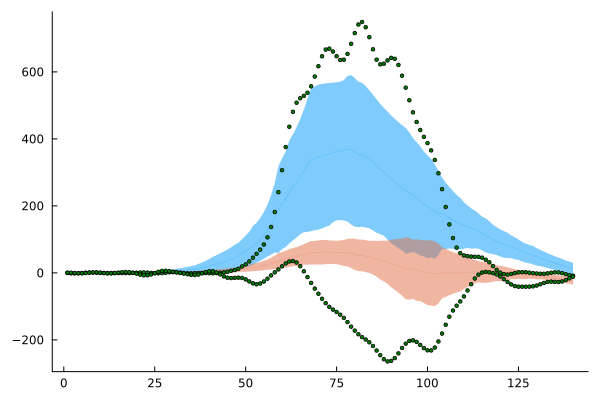

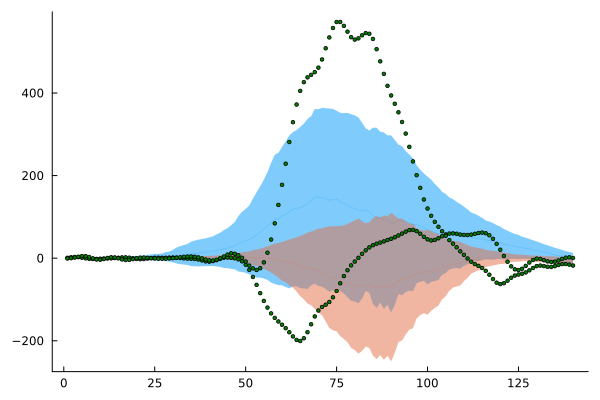

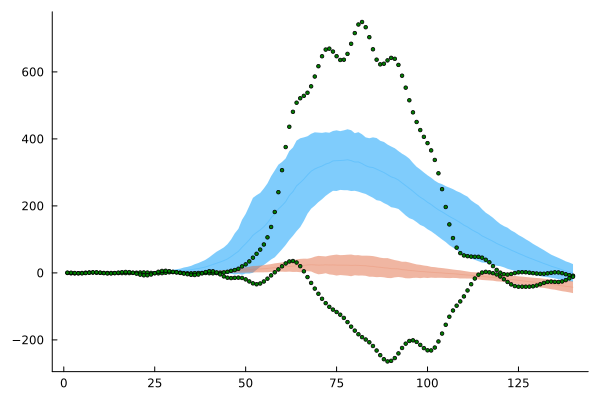

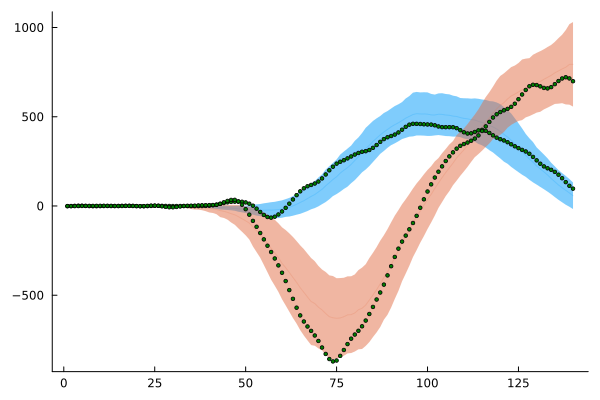

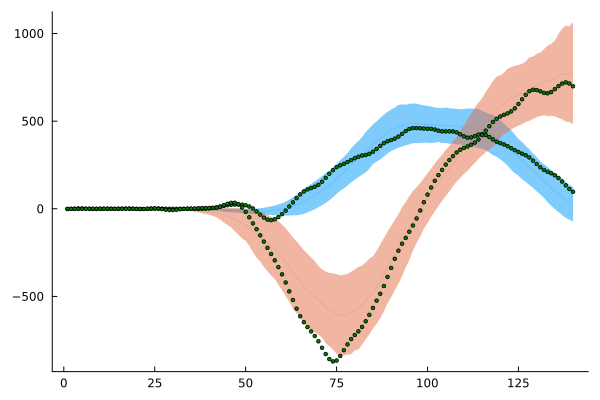

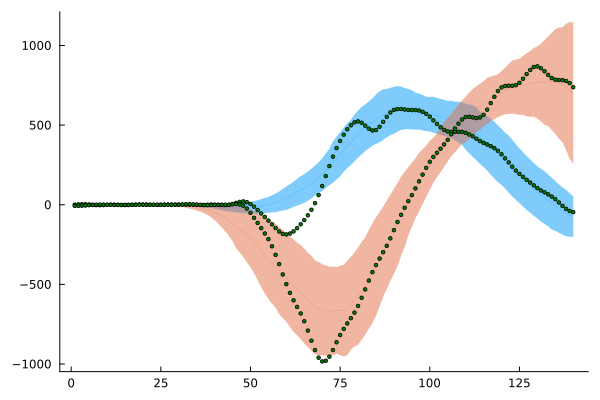

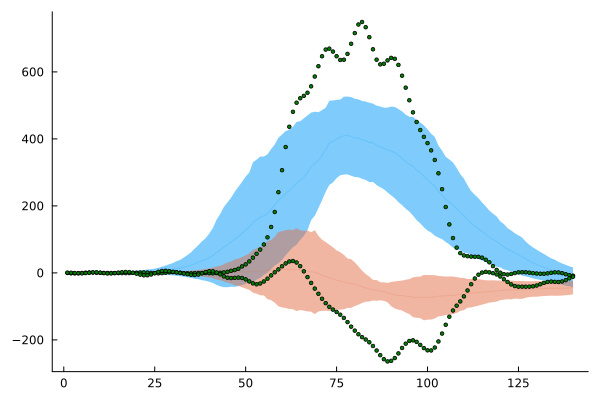

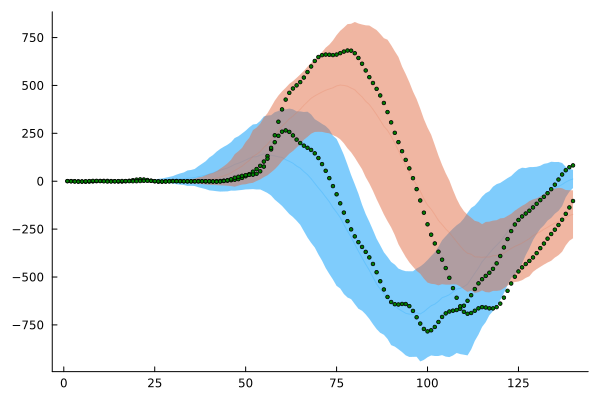

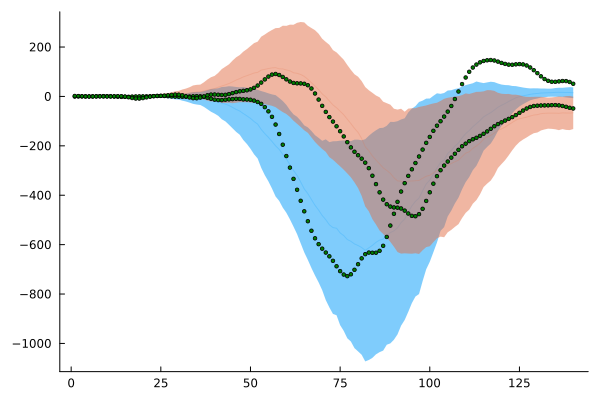

In [28]:
model, θ_best = train(model, p, st, train_loader, val_loader, 5000, 500);

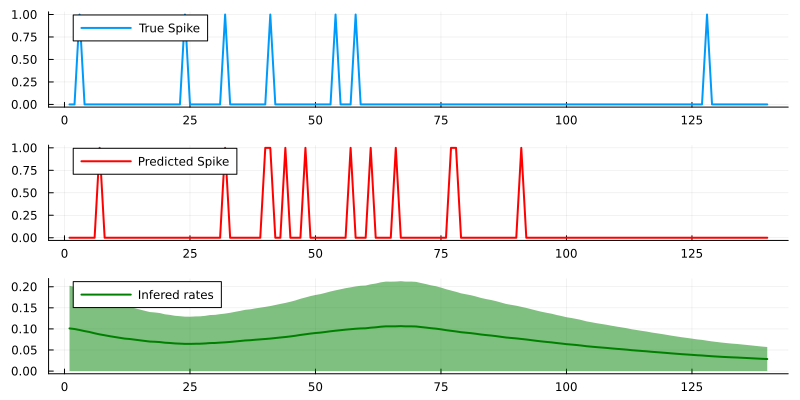

In [104]:
u, y_n, y_b = first(train_loader) 
(ŷ_n, ŷ_b), _, x = predict(model, y_n, u, ts, θ_best, st, 20)
sample = 8
ch = 9
ŷₘ = dropmean(ŷ_n, dims=4)
ŷₛ = dropmean(ŷ_n, dims=4)
dist = Poisson.(ŷₘ)
pred_spike = rand.(dist)
xₘ = dropmean(x, dims=4)
val_bps = bits_per_spike(ŷₘ, y_n)

p1 = plot(transpose(y_n[ch:ch,:,sample]), label="True Spike", lw=2)
p2 = plot(transpose(pred_spike[ch:ch,:,sample]), label="Predicted Spike", lw=2, color="red")
p3 = plot(transpose(ŷₘ[ch:ch,:,sample]), ribbon=transpose(ŷₛ[ch:ch,:,sample]), label="Infered rates", lw=2, color="green")

plot(p1, p2,p3, layout=(3,1), size=(800, 400), legend=:topleft)


In [105]:
savefig("spike_prediction.png")

"/Users/ahmed.elgazzar/Code/MyPackages/NeuroDynamics/NeuroDynamics/examples/spike_prediction.png"

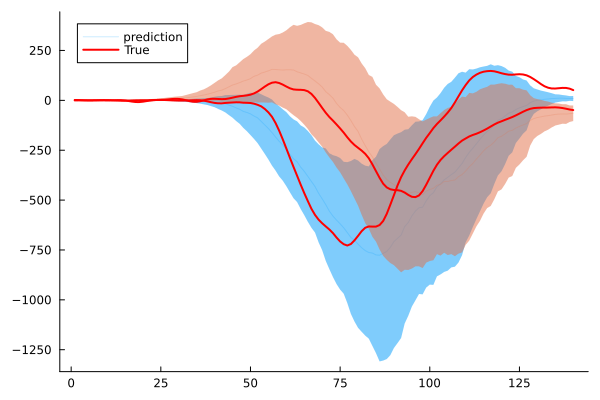

In [111]:
s = 13
plot_samples(ŷ_b[1], s)
plot!(transpose(y_b[:,:,s]), label=["True" nothing], lw=2, color="red", legend=:topleft)
